In [1]:
import os
import time
import glob
import torch

import nvtabular as nvt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from nvtabular.loader.torch import TorchAsyncItr, DLDataLoader
from nvtabular.framework_utils.torch.models import Model
from nvtabular.framework_utils.torch.utils import process_epoch

/conda/envs/rapids/lib/python3.7/site-packages/numba/cuda/envvars.py:17: NumbaWarning: 
Environment variables with the 'NUMBAPRO' prefix are deprecated and consequently ignored, found use of NUMBAPRO_NVVM=/usr/local/cuda/nvvm/lib64/libnvvm.so.

For more information about alternatives visit: ('http://numba.pydata.org/numba-doc/latest/cuda/overview.html', '#cudatoolkit-lookup')
  warnings.warn(errors.NumbaWarning(msg))
/conda/envs/rapids/lib/python3.7/site-packages/numba/cuda/envvars.py:17: NumbaWarning: 
Environment variables with the 'NUMBAPRO' prefix are deprecated and consequently ignored, found use of NUMBAPRO_LIBDEVICE=/usr/local/cuda/nvvm/libdevice/.

For more information about alternatives visit: ('http://numba.pydata.org/numba-doc/latest/cuda/overview.html', '#cudatoolkit-lookup')
  warnings.warn(errors.NumbaWarning(msg))


In [2]:
def rmspe_func(y_pred, y):
    "Return y_pred and y to non-log space and compute RMSPE"
    y_pred, y = torch.exp(y_pred) - 1, torch.exp(y) - 1
    pct_var = (y_pred - y) / y
    return (pct_var**2).mean().pow(0.5)

class CustomDataset(Dataset):
  """Simple dataset class for dataloader"""
  def __init__(self, df, cats, conts, labels):
    """Initialize the CustomDataset"""
    self.cats = df[cats].astype(np.int64).values
    self.conts = df[conts].astype(np.float32).values
    self.labels = df[labels].astype(np.float32).values
  
  def __len__(self):
    """Return the total length of the dataset"""
    dataset_size = self.cats.shape[0]
    return dataset_size
  
  def __getitem__(self, idx):
    """Return the batch given the indices"""
    return self.cats[idx], self.conts[idx], self.labels[idx]

def process_epoch(dataloader, model, train=False, optimizer=None, loss_func=torch.nn.MSELoss(), pyt_dl=False):
    """
    The controlling function that loads data supplied via a dataloader to a model. Can be redefined
    based on parameters.
    Parameters
    -----------
    dataloader : iterator
        Iterator that contains the dataset to be submitted to the model.
    model : torch.nn.Module
        Pytorch model to run data through.
    train : bool
        Indicate whether dataloader contains training set.
    optimizer : object
        Optimizer to run in conjunction with model.
    loss_func : function
        Loss function to use, default is MSELoss.
    """
    model.train(mode=train)
    with torch.set_grad_enabled(train):
        y_list, y_pred_list = [], []
        for x_cat, x_cont, y in iter(dataloader):
            if pyt_dl:
                x_cat, x_cont, y = x_cat.cuda(), x_cont.cuda(), torch.squeeze(y).cuda()
            y_list.append(y.detach())
            y_pred = model(x_cat, x_cont)
            y_pred_list.append(y_pred.detach())
            loss = loss_func(y_pred, y)
            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
    y = torch.cat(y_list)
    y_pred = torch.cat(y_pred_list)
    epoch_loss = loss_func(y_pred, y).item()
    return epoch_loss, y_pred, y

def run_benchmark(dl_train, dl_valid, pyt_dl=False):
    model = Model(
        embedding_table_shapes=EMBEDDING_TABLE_SHAPES,
        num_continuous=len(CONTINUOUS_COLUMNS),
        emb_dropout=EMBEDDING_DROPOUT_RATE,
        layer_hidden_dims=HIDDEN_DIMS,
        layer_dropout_rates=DROPOUT_RATES,
        max_output=MAX_LOG_SALES_PREDICTION
    ).to('cuda')

    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    hist_dl = []
    time_start = time.time()
    for epoch in range(EPOCHS):
        train_loss, y_pred, y = process_epoch(dl_train, model, train=True, optimizer=optimizer, pyt_dl=pyt_dl)
        train_rmspe = rmspe_func(y_pred, y)
        valid_loss, y_pred, y = process_epoch(dl_valid, model, train=False, pyt_dl=pyt_dl)
        valid_rmspe = rmspe_func(y_pred, y)
        hist_dl.append({
            'epoch': epoch, 
            'train_loss': train_loss, 
            'train_rmspe': train_rmspe.item(), 
            'valid_loss': valid_loss, 
            'valid_rmspe': valid_rmspe.item()
        })
        print(f'Epoch {epoch:02d}. Train loss: {train_loss:.4f}. Train RMSPE: {train_rmspe:.4f}. Valid loss: {valid_loss:.4f}. Valid RMSPE: {valid_rmspe:.4f}.')

    time_end = time.time()
    return time_end-time_start, hist_dl

In [3]:
DATA_DIR = os.environ.get("OUTPUT_DATA_DIR", "../../data")

CATEGORICAL_COLUMNS = [
    'Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw'
]

CONTINUOUS_COLUMNS = [
    'CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday'
]
LABEL_COLUMNS = ['Sales']

COLUMNS = CATEGORICAL_COLUMNS + CONTINUOUS_COLUMNS + LABEL_COLUMNS

In [4]:
! ls $DATA_DIR

ross_pre  test.csv  train.csv  valid.csv


In [5]:
PREPROCESS_DIR = os.path.join(DATA_DIR, 'ross_pre')
PREPROCESS_DIR_TRAIN = os.path.join(PREPROCESS_DIR, 'train')
PREPROCESS_DIR_VALID = os.path.join(PREPROCESS_DIR, 'valid')

In [6]:
PREPROCESS_DIR_TRAIN, PREPROCESS_DIR_VALID

('../../data/ross_pre/train', '../../data/ross_pre/valid')

In [7]:
EMBEDDING_DROPOUT_RATE = 0.04
DROPOUT_RATES = [0.001, 0.01]
HIDDEN_DIMS = [1000, 500]
BATCH_SIZE = 65536
LEARNING_RATE = 0.001
EPOCHS = 75

# TODO: Calculate on the fly rather than recalling from previous analysis.
MAX_SALES_IN_TRAINING_SET = 38722.0
MAX_LOG_SALES_PREDICTION = 1.2 * np.log(MAX_SALES_IN_TRAINING_SET + 1.0)

# It's possible to use defaults defined within NVTabular.
EMBEDDING_TABLE_SHAPES = {
    'Assortment': (4, 3),
    'CompetitionMonthsOpen': (26, 10),
    'CompetitionOpenSinceYear': (24, 9),
    'Day': (32, 11),
    'DayOfWeek': (8, 5),
    'Events': (23, 9),
    'Month': (13, 7),
    'Promo2SinceYear': (9, 5),
    'Promo2Weeks': (27, 10),
    'PromoInterval': (5, 4),
    'Promo_bw': (7, 5),
    'Promo_fw': (7, 5),
    'SchoolHoliday_bw': (9, 5),
    'SchoolHoliday_fw': (9, 5),
    'State': (13, 7),
    'StateHoliday': (3, 3),
    'StateHoliday_bw': (4, 3),
    'StateHoliday_fw': (4, 3),
    'Store': (1116, 81),
    'StoreType': (5, 4),
    'Week': (53, 15),
    'Year': (4, 3)
}

# Here, however, we will use fast.ai's rule for embedding sizes.
for col in EMBEDDING_TABLE_SHAPES:
    EMBEDDING_TABLE_SHAPES[col] = (EMBEDDING_TABLE_SHAPES[col][0], min(600, round(1.6 * EMBEDDING_TABLE_SHAPES[col][0] ** 0.56)))

TRAIN_PATHS = sorted(glob.glob(os.path.join(PREPROCESS_DIR_TRAIN, '*.parquet')))
VALID_PATHS = sorted(glob.glob(os.path.join(PREPROCESS_DIR_VALID, '*.parquet')))

In [8]:
TRAIN_PATHS, VALID_PATHS

(['../../data/ross_pre/train/0.0d56b2c05b054c65a0e824f59d1e6376.parquet',
  '../../data/ross_pre/train/1.ec29dddd3e344661aedd1675a7f6a52f.parquet'],
 ['../../data/ross_pre/valid/part.0.parquet'])

### PyTorch Data Loaders

In [9]:
pd_train = pd.concat([pd.read_parquet(x) for x in TRAIN_PATHS])
pd_valid = pd.concat([pd.read_parquet(x) for x in VALID_PATHS])

ds_train = CustomDataset(pd_train, cats=sorted(CATEGORICAL_COLUMNS), conts=CONTINUOUS_COLUMNS, labels=LABEL_COLUMNS)
ds_valid = CustomDataset(pd_valid, cats=sorted(CATEGORICAL_COLUMNS), conts=CONTINUOUS_COLUMNS, labels=LABEL_COLUMNS)

dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True)
dl_valid = DataLoader(ds_valid, batch_size=BATCH_SIZE, shuffle=True)

In [10]:
pyt_dl_runtime, pyt_dl_hist = run_benchmark(dl_train, dl_valid, pyt_dl=True)

Epoch 00. Train loss: 9.8597. Train RMSPE: 3.6975. Valid loss: 4.5366. Valid RMSPE: 0.8580.
Epoch 01. Train loss: 4.4227. Train RMSPE: 0.8297. Valid loss: 3.1796. Valid RMSPE: 0.8100.
Epoch 02. Train loss: 3.0119. Train RMSPE: 0.7900. Valid loss: 2.1605. Valid RMSPE: 0.7402.
Epoch 03. Train loss: 1.7195. Train RMSPE: 0.6897. Valid loss: 0.9496. Valid RMSPE: 0.5768.
Epoch 04. Train loss: 0.6886. Train RMSPE: 0.5220. Valid loss: 0.3230. Valid RMSPE: 0.4287.
Epoch 05. Train loss: 0.2568. Train RMSPE: 0.4868. Valid loss: 0.1950. Valid RMSPE: 0.5068.
Epoch 06. Train loss: 0.1973. Train RMSPE: 0.5807. Valid loss: 0.1865. Valid RMSPE: 0.5780.
Epoch 07. Train loss: 0.1734. Train RMSPE: 0.5475. Valid loss: 0.1478. Valid RMSPE: 0.4534.
Epoch 08. Train loss: 0.1504. Train RMSPE: 0.4770. Valid loss: 0.1291. Valid RMSPE: 0.3947.
Epoch 09. Train loss: 0.1375. Train RMSPE: 0.4203. Valid loss: 0.1177. Valid RMSPE: 0.3743.
Epoch 10. Train loss: 0.1276. Train RMSPE: 0.4055. Valid loss: 0.1089. Valid RMS

### NVT Data Loaders

In [11]:
# TensorItrDataset returns a single batch of x_cat, x_cont, y.
collate_fn = lambda x: x

train_dataset = TorchAsyncItr(nvt.Dataset(TRAIN_PATHS), batch_size=BATCH_SIZE, cats=CATEGORICAL_COLUMNS, conts=CONTINUOUS_COLUMNS, labels=LABEL_COLUMNS)
train_loader = DLDataLoader(train_dataset, batch_size=None, collate_fn=collate_fn, pin_memory=False, num_workers=0)

valid_dataset = TorchAsyncItr(nvt.Dataset(VALID_PATHS), batch_size=BATCH_SIZE, cats=CATEGORICAL_COLUMNS, conts=CONTINUOUS_COLUMNS, labels=LABEL_COLUMNS)
valid_loader = DLDataLoader(valid_dataset, batch_size=None, collate_fn=collate_fn, pin_memory=False, num_workers=0)

In [12]:
nvt_dl_runtime, nvt_dl_hist = run_benchmark(train_loader, valid_loader, pyt_dl=False)

Epoch 00. Train loss: 7.2083. Train RMSPE: 1.7159. Valid loss: 3.4202. Valid RMSPE: 0.8248.
Epoch 01. Train loss: 3.8073. Train RMSPE: 0.8153. Valid loss: 2.4431. Valid RMSPE: 0.7659.
Epoch 02. Train loss: 2.4504. Train RMSPE: 0.7548. Valid loss: 1.3596. Valid RMSPE: 0.6490.
Epoch 03. Train loss: 1.1727. Train RMSPE: 0.6131. Valid loss: 0.6090. Valid RMSPE: 0.4959.
Epoch 04. Train loss: 0.3831. Train RMSPE: 0.4846. Valid loss: 0.2370. Valid RMSPE: 0.5095.
Epoch 05. Train loss: 0.2144. Train RMSPE: 0.5881. Valid loss: 0.2158. Valid RMSPE: 0.6340.
Epoch 06. Train loss: 0.1958. Train RMSPE: 0.5950. Valid loss: 0.1770. Valid RMSPE: 0.5165.
Epoch 07. Train loss: 0.1591. Train RMSPE: 0.4914. Valid loss: 0.1384. Valid RMSPE: 0.4129.
Epoch 08. Train loss: 0.1399. Train RMSPE: 0.4189. Valid loss: 0.1198. Valid RMSPE: 0.3829.
Epoch 09. Train loss: 0.1307. Train RMSPE: 0.4095. Valid loss: 0.1079. Valid RMSPE: 0.3781.
Epoch 10. Train loss: 0.1225. Train RMSPE: 0.4060. Valid loss: 0.1038. Valid RMS

### Comparison

In [14]:
pd_nvt = pd.DataFrame(nvt_dl_hist)
pd_pyt = pd.DataFrame(pyt_dl_hist)

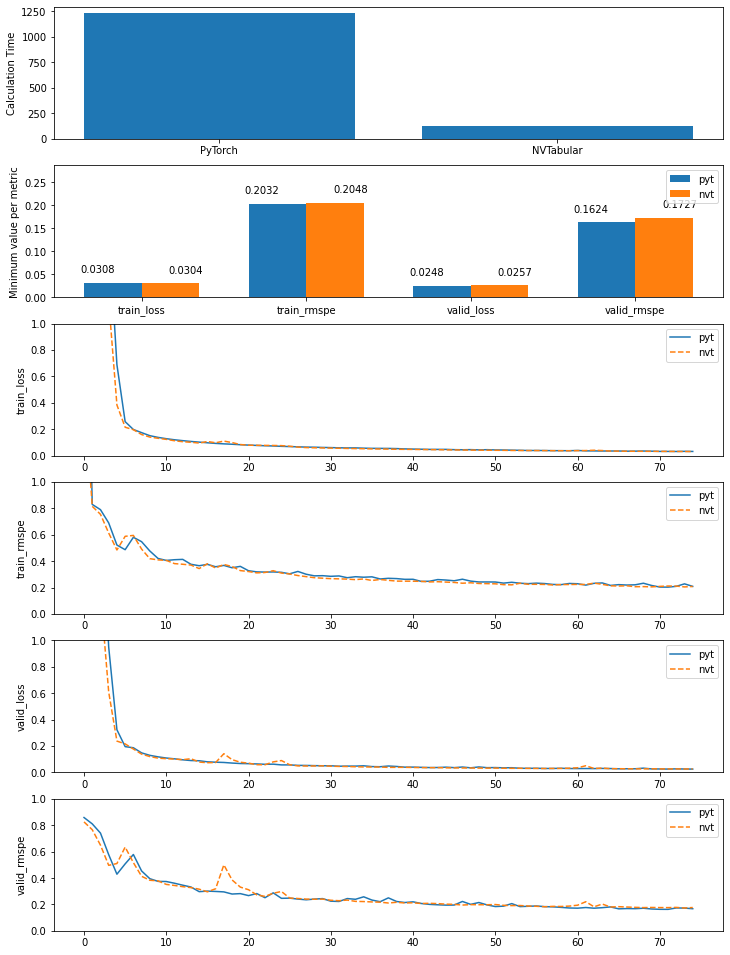

In [51]:
keys = [x for x in pd_pyt.columns if x not in ['epoch']]
keys_ylim = {'train_loss': (0,1), 'train_loss': (0,1), 'train_loss': (0,1), 'train_loss': (0,1)}
width = 0.35

fig, ax = plt.subplots(2+len(keys), 1, figsize=(12,17))

# Runtime
ax[0].bar(x=['PyTorch', 'NVTabular'], height=[pyt_dl_runtime, nvt_dl_runtime])
ax[0].set_ylabel('Calculation Time')

# Min Convergence
nvt_min = [pd_nvt[key].min() for key in keys]
pyt_min = [pd_pyt[key].min() for key in keys]
x = np.asarray(list(range(len(keys))))

ax[1].bar(x - width/2, pyt_min, width, label='pyt')
ax[1].bar(x + width/2, nvt_min, width, label='nvt')
ax[1].set_xticks(x)
ax[1].set_xticklabels(keys)
ax[1].set_ylabel('Minimum value per metric')

for x, y in enumerate(pyt_min):
    ax[1].annotate("{:.4f}".format(y), 
                     (x - width/1.3,y),
                     textcoords="offset points",
                     xytext=(0,10),
                     ha='center')

for x, y in enumerate(nvt_min):
    ax[1].annotate("{:.4f}".format(y), 
                     (x + width/1.3,y),
                     textcoords="offset points",
                     xytext=(0,10),
                     ha='center')

ax[1].set_ylim(0, max(nvt_min+pyt_min)*1.4)
ax[1].legend()

# Convergence
for i in range(len(keys)):
    ax[i+2].plot(pd_pyt[keys[i]], '-', label='pyt')
    ax[i+2].plot(pd_nvt[keys[i]], '--', label='nvt')
    ax[i+2].legend()
    ax[i+2].set_ylabel(keys[i])
    ax[i+2].set_ylim(0,1)

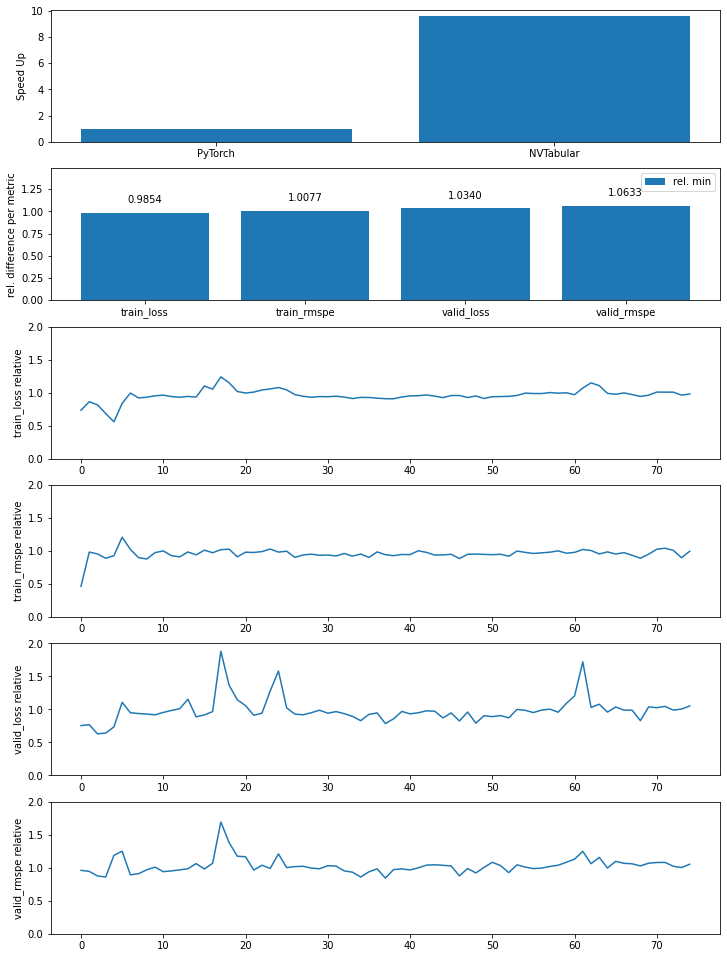

In [52]:
keys = [x for x in pd_pyt.columns if x not in ['epoch']]
keys_ylim = {'train_loss': (0,1), 'train_loss': (0,1), 'train_loss': (0,1), 'train_loss': (0,1)}

fig, ax = plt.subplots(2+len(keys), 1, figsize=(12,17))

# Runtime
ax[0].bar(x=['PyTorch', 'NVTabular'], height=[pyt_dl_runtime/pyt_dl_runtime, pyt_dl_runtime/nvt_dl_runtime])
ax[0].set_ylabel('Speed Up')

# Min Convergence
rel_min = [pd_nvt[key].min()/pd_pyt[key].min() for key in keys]
x = np.asarray(list(range(len(keys))))

ax[1].bar(x, rel_min, label='rel. min')
ax[1].set_xticks(x)
ax[1].set_xticklabels(keys)
ax[1].set_ylabel('rel. difference per metric')

for x, y in enumerate(rel_min):
    ax[1].annotate("{:.4f}".format(y), 
                     (x,y),
                     textcoords="offset points",
                     xytext=(0,10),
                     ha='center')

ax[1].set_ylim(0, max(rel_min)*1.4)
ax[1].legend()

# Convergence
for i in range(len(keys)):
    y_values = pd_nvt[keys[i]].values/pd_pyt[keys[i]].values
    ax[i+2].plot(y_values)
    ax[i+2].set_ylabel(keys[i] + ' ' + 'relative')
    ax[i+2].set_ylim(0,2)
    
    #for x, y in enumerate(y_values.tolist()):
    #    ax[i+2].annotate("{:.2f}".format(y)pyt_min, 
    #                     (x,y),
    #                     textcoords="offset points",
    #                     xytext=(0,10),
    #                     ha='center')    

([<matplotlib.axis.XTick at 0x7f1b40b63490>,
 [Text(1, 0, 'train_loss'),
  Text(2, 0, 'train_rmspe'),
  Text(3, 0, 'valid_loss'),
  Text(4, 0, 'valid_rmspe')])

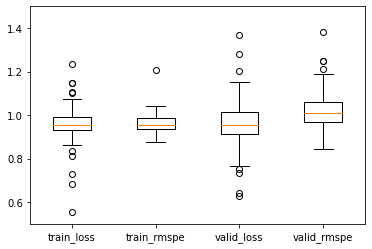

In [53]:
y_values_boxplot = [pd_nvt[keys[i]].values/pd_pyt[keys[i]].values for i in range(len(keys))]

plt.boxplot(y_values_boxplot)
plt.ylim(0.5, 1.5)
plt.xticks(list(range(1,1+len(keys))), keys)